<a href="https://colab.research.google.com/github/fcoelhomrc/MachineLearning/blob/main/TAAPC_Assignments%5Cassignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torchtext
from tqdm import tqdm
from collections import Counter, OrderedDict

In [2]:
url_train = "https://raw.githubusercontent.com/fcoelhomrc/MachineLearning/main/TAAPC_Assignments/imdb_train.csv"
url_test = "https://raw.githubusercontent.com/fcoelhomrc/MachineLearning/main/TAAPC_Assignments/imdb_test.csv"

imdb_train = pd.read_csv(url_train)
imdb_test = pd.read_csv(url_test, names=imdb_train.columns)

In [3]:
imdb_test.head()

,review,sentiment
0,"I saw the film many times, and every time I am...",negative
1,I loved KOLCHAK: THE NIGHT STALKER since I saw...,positive
2,This feels as if it is a Czech version of Pear...,positive
3,"When, oh, when will someone like Anchor Bay or...",positive
4,"""Just before dawn "" is one of the best slasher...",positive


In [4]:
print(imdb_train.shape, imdb_test.shape)
print(imdb_train.columns, imdb_test.columns)

(45000, 2) (5000, 2)
Index(['review', 'sentiment'], dtype='object') Index(['review', 'sentiment'], dtype='object')


The outline of this project is
1. Pre-process the data, defining a vocabulary and converting it to a sparse representation
2. Use an embedding layer to transform into a dense representation
3. Use each embedded sequence as input to a GRU layer, and then use a Linear layer with sigmoid activation to map output into a single binary prediction (many-to-one model)

We will have to deal with different length sequences while mini-batching. [This post](https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e) and [this repository](https://gist.github.com/HarshTrivedi/f4e7293e941b17d19058f6fb90ab0fec) explain PyTorch implementations to do that.

Generate the vocabulary

In [5]:
tokenizer = torchtext.data.get_tokenizer("basic_english")

def get_vocab_freq(data):
    counter = Counter()
    for sentence in data["review"]:
        tokenized_sentence = tokenizer(sentence)
        counter.update(tokenized_sentence)
    return OrderedDict(counter)

imdb_data = pd.concat([imdb_train, imdb_test], axis=0, ignore_index=True) # fetch vocab considering complete data

vocab_freq = get_vocab_freq(imdb_data)

pad_token = "<pad>" # Token representing padding
vocab = torchtext.vocab.vocab(vocab_freq, min_freq=50,
                              specials=[pad_token], special_first=True)
vocab.set_default_index(-1) # Unknown words will return -1

In [6]:
len(vocab)

11264

In [7]:
sequence_len = [len(tokenizer(seq)) for seq in imdb_data["review"]]
PADDED_LENGTH = max(sequence_len)
PADDED_LENGTH

2752

Create a custom `Dataset` and `DataLoader` to automatically handle mini-batching.

The `IMDBDataset` object should store each review in a sparse representation and map the sentiment into binary categories: `{0: "negative", 1: "positive"}`.

Moreover, it will pad each review with `<pad>` tokens. This will be managed later by the `pack_padded_sequence` and `pad_packed_sequence` functions.

In [8]:
class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, data, vocab, tokenizer, max_len, pad_token):
        self.inputs = []
        self.targets = []
        self.lengths = []

        print(f"Loading data...")
        print(f"Padding inputs...")
        for sentence in data["review"]:
            # Tokenize review
            tokenized_sentence = tokenizer(sentence)
            # Skip unknown tokens
            padded_sentence = [vocab[tk] for tk in tokenized_sentence if vocab[tk] >= 0] 
            # Save length before padding
            self.lengths.append(len(padded_sentence)) 
            # Apply padding
            padding_size = max_len - len(padded_sentence)
            padded_sentence.extend([vocab[pad_token]]*padding_size)
            # Append result
            self.inputs.append(padded_sentence)
        print("Finished padding inputs. Processing labels...")
        for label in data["sentiment"]:
            self.targets.append(0 if label == "negative" else 1)
        print("Done.")

    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        # Must also return original length before padding
        return {"inputs": self.inputs[idx],
                "targets": self.targets[idx],
                "lengths": self.lengths[idx]}
        # return self.inputs[idx], self.targets[idx], self.lengths[idx]

Instantiate the `DataLoaders`, splitting the train data into train/validation sets. For the train/validation splitting, refer [to this post.](https://clay-atlas.com/us/blog/2021/08/25/pytorch-en-random-split-data-set/)

In [9]:
train_dataset = IMDBDataset(imdb_train, vocab, tokenizer, PADDED_LENGTH, pad_token)
test_dataset = IMDBDataset(imdb_test, vocab, tokenizer, PADDED_LENGTH, pad_token)

train_split = int(0.9 * len(train_dataset))
validation_split = len(train_dataset) - train_split
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset,
                                                                  [train_split, validation_split])

BATCH_SIZE = 128
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

Loading data...
Padding inputs...
Finished padding inputs. Processing labels...
Done.
Loading data...
Padding inputs...
Finished padding inputs. Processing labels...
Done.


Now we need to define our model:

[![](https://mermaid.ink/img/pako:eNplkU9PwzAMxb9K5BNIm9CuparEOokLpyFOZKqyxrQWSRry5zBt--54bWFM-BTF7_f84hyhHTRCAV1Qvhcv20fpBNfTuwRyPicJO7FcVicJ0asQUcJJrLmJdo9ak-skiHIfKlFGq4ypxNhoNFlRPkxXu8lyPftodJNNzTbP27db3GXbGHXAEH_5Cf9fN1xPmo2bmFTCKwnz7HqeTQmDMOjuIn5ldC3ej0H-iES94liGHKpwxVc_O6DODqQv0IZlPqCmNtHgRikswGKwijQv9HhBJaQeLb-24KNW4VOCdGfWqZyG14NroUgh4wKy1xx8Q4r_wULxoUzE8zegXYC2)](https://mermaid.live/edit#pako:eNplkU9PwzAMxb9K5BNIm9CuparEOokLpyFOZKqyxrQWSRry5zBt--54bWFM-BTF7_f84hyhHTRCAV1Qvhcv20fpBNfTuwRyPicJO7FcVicJ0asQUcJJrLmJdo9ak-skiHIfKlFGq4ypxNhoNFlRPkxXu8lyPftodJNNzTbP27db3GXbGHXAEH_5Cf9fN1xPmo2bmFTCKwnz7HqeTQmDMOjuIn5ldC3ej0H-iES94liGHKpwxVc_O6DODqQv0IZlPqCmNtHgRikswGKwijQv9HhBJaQeLb-24KNW4VOCdGfWqZyG14NroUgh4wKy1xx8Q4r_wULxoUzE8zegXYC2)

Some comments:
- Unlike the Word2Vec model implemented in class, we don't need to use a `nn.Linear` layer to map from embedding space to vocabulary space. 
- The model is based around a `nn.GRU` layer, which allow us to chain many GRU units for processing each sequence. In the end, we are only interest in the output of the final GRU layer. 
- Note that we will use `torch.nn.utils.rnn.pack_padded_sequence` to feed input to GRU as to avoid flooding it with padding tokens. The output will still be in packed form, but it is not necessary to reverse the operation since our prediction is based upon the hidden state.
- We don't need to include `nn.Sigmoid` explicitly, since our loss function (`nn.BCEWithLogitsLoss`) will implement it for us (with more numerical stability, [c.f. documentation](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html)).

In [36]:
class GRUPredictor(nn.Module):

    def __init__(self, vocab_size,
                 hidden_size, num_layers,
                 embed_dim, embed_max_norm=None,
                 is_bidirectional=False):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim,
                                      padding_idx=0,
                                      max_norm=embed_max_norm)
        self.gru = nn.GRU(input_size=embed_dim, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True, bidirectional=is_bidirectional)
        self.linear = nn.Linear(hidden_size, 1)
        self.embed_dim = embed_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = is_bidirectional
        
    def forward(self, inputs, unpadded_lengths):
        # sort inputs by descending unpadded length
        unpadded_lengths, sort_idx = unpadded_lengths.sort(descending=True)
        unpadded_lengths = unpadded_lengths.cpu().numpy()
        inputs = inputs[sort_idx]
        # embed inputs
        embedded_inputs = self.embedding(inputs)
        BS, T, _ = embedded_inputs.shape # X -> batch, steps, embed_dim 
        # initialize hidden state
        D = 2 if self.bidirectional else 1
        self.hidden_state = torch.zeros((D*self.num_layers, BS, self.hidden_size),
                                        device=inputs.device)
        # pack_padded_sequence so that padded items in the sequence won't be shown to the LSTM
        X = torch.nn.utils.rnn.pack_padded_sequence(embedded_inputs, unpadded_lengths,
                                                    batch_first=True)
        # rnn pass
        X, self.hidden_state = self.gru(X, self.hidden_state)
        # prediction using final layer output
        output = self.linear(self.hidden_state[-1])
        return output

Now we need to write the training loop, etc.
Most of the code below is based on what was supplied to us in the earlier modules.

Comment about `nn.functional.binary_cross_entropy_with_logits`: the targets $y$ need to be a float tensor, since the loss function can work with soft labels representing probability of the positive class.
[Source](https://discuss.pytorch.org/t/multi-label-binary-classification-result-type-float-cant-be-cast-to-the-desired-output-type-long/117915/3)

In [37]:
EMBED_SIZE = 80
HIDDEN_SIZE = 128
NUM_LAYERS = 2
LEARNING_RATE = 1e-3
NUM_EPOCHS = 5
BIDIRECTIONAL = True

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('DEVICE:', DEVICE)

model = GRUPredictor(len(vocab), HIDDEN_SIZE, NUM_LAYERS,
                     EMBED_SIZE, embed_max_norm=True, is_bidirectional=BIDIRECTIONAL).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

DEVICE: cuda


In [38]:
print(model)

GRUPredictor(
  (embedding): Embedding(11264, 80, padding_idx=0, max_norm=True)
  (gru): GRU(80, 128, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=128, out_features=1, bias=True)
)


In [39]:
def evaluate(model, data_loader, **kwargs):
    loss_fn = kwargs.get("loss_fn", nn.functional.binary_cross_entropy_with_logits)
    device = kwargs.get("device", torch.device("cpu"))
    
    model.eval() # set model to evaluation mode
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    avg_loss = 0.
    for i, batch in pbar:

        batch["inputs"] = (torch.stack(batch["inputs"]).T).to(device)
        batch["targets"] = batch["targets"].float().to(device)
        
        model.zero_grad() # initialize gradients to zero
        with torch.no_grad(): # no need to compute gradients
            preds = model(batch["inputs"], batch["lengths"])
        loss = loss_fn(preds.squeeze(), batch["targets"])
        avg_loss += loss.item()

        pbar.set_description(f"loss = {loss:.3f}")
    avg_loss /= len(data_loader)
    return avg_loss

def fit(model, train_loader, val_loader, optimizer, **kwargs):
    num_epochs = kwargs.get("num_epochs", 100)
    loss_fn = kwargs.get("loss_fn", nn.functional.binary_cross_entropy_with_logits)
    device = kwargs.get("device", torch.device("cpu"))
    
    train_loss_hist, val_loss_hist = [], []
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        model.train() # set model to training mode
        train_loss = 0.
        pbar = tqdm(enumerate(train_loader), total=len(train_loader))
        for i, batch in pbar:
            
            batch["inputs"] = (torch.stack(batch["inputs"]).T).to(device)
            batch["targets"] = batch["targets"].float().to(device)
    
            model.zero_grad() # initialize gradients to zero
            preds = model(batch["inputs"], batch["lengths"]) # forward pass
            loss = loss_fn(preds.squeeze(), batch["targets"]) # loss computation
            loss.backward() # computing gradients (backward pass)
            optimizer.step() # updating the parameters of the model
            
            train_loss += loss.item()
            pbar.set_description(f"loss = {loss:.3f}")
        train_loss /= len(train_loader)
        print(f"Train loss: {train_loss:.3f}")
        train_loss_hist.append(train_loss)
        
        
        val_loss = evaluate(model, val_loader, loss_fn=loss_fn, device=device)
        print(f"Validation loss: {val_loss:.3f}")
        val_loss_hist.append(val_loss)
        
    return train_loss_hist, val_loss_hist


In [40]:
train_loss, val_loss = fit(model, train_dataloader, validation_dataloader,
                           optimizer, num_epochs=NUM_EPOCHS, device=DEVICE)


Epoch 1/5


loss = 0.694:  15%|██████████▎                                                        | 49/317 [00:07<00:41,  6.51it/s]


KeyboardInterrupt: 

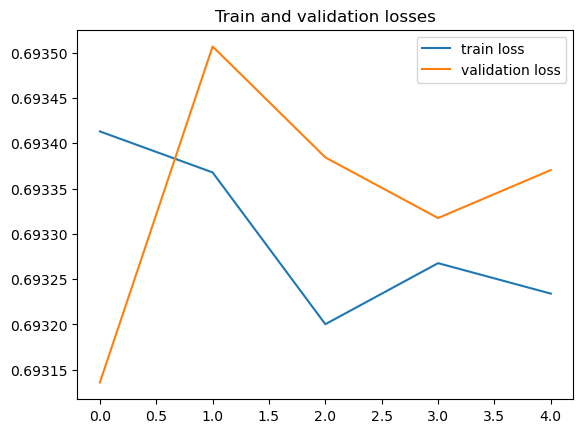

In [31]:
plt.title('Train and validation losses')
plt.plot(range(len(train_loss)), train_loss, label='train loss')
plt.plot(range(len(val_loss)), val_loss, label='validation loss')
plt.legend()
plt.show()

In [42]:
model_name = f"GRU_{NUM_EPOCHS}_E{EMBED_SIZE}_H{HIDDEN_SIZE}_" +\
             f"N{NUM_LAYERS}_Bi{1 if BIDIRECTIONAL else 0}.pt"
torch.save(model.state_dict(), model_name)

### Report

#### Hyper-parameters (batch_size, embed_dim, hidden_dim, num_layers, lr, num_epochs)
- (128, 100, 64, 2, 1e-3, 10): train loss decayed very little $\approx 0.693$, validation loss unstable

- (128, 100, 64, 2, 1e-2, 10): the loss wasn't minimized, lr too high?

- (128, 80, 128, 1, 1e-3, 5): nothing changed

**Maybe go bi-directional GRU?**

#### Hyper-parameters (batch_size, embed_dim, hidden_dim, num_layers, lr, num_epochs, bi)
- (128, 80, 128, 1, 1e-3, 5, True): 